In [12]:
# Dataset
import kagglehub
from kagglehub import KaggleDatasetAdapter

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # NOTE: imblearn Pipeline (not sklearn)

import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Downloading the latest version of the dataset
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")

print("Path to dataset files:", path)


Path to dataset files: /Users/carson_nov_2025/.cache/kagglehub/datasets/maharshipandya/-spotify-tracks-dataset/versions/1


In [14]:
df = pd.read_csv(path + '/dataset.csv')
df = df.drop(df.columns[0], axis=1)
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [45]:
# Define features
numeric_features = [
    'danceability', 'energy', 'loudness',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo'
]

outlier_features = [
    'duration_ms', 
]

binary_features = ['explicit', 'mode']

categorical_features = ['key', 'time_signature']

# Using Target Encoder to prevent us from creating thousands of buckets
categorical_large_features = ['track_genre', 'artists'] # optional: add 'artists'

target = 'popularity'

# Preprocess numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

outlier_numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Preprocess binary features (no scaling needed)
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Preprocess categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

categorical_large_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('target', TargetEncoder())
])

# Combine transformers0
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('out', outlier_numeric_transformer, outlier_features),
        ('bin', binary_transformer, binary_features),
        ('cat', categorical_transformer, categorical_features),
        ('cat_xl', categorical_large_transformer, categorical_large_features)
    ]
)

In [46]:
df["popular"] = (df["popularity"] >= 60).astype(int)   # 1 = popular, 0 = not popular

features = numeric_features + outlier_features + binary_features + categorical_features + categorical_large_features

X = df[features]
y = df["popular"]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [48]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

In [49]:
param_grid = {
    'smote__k_neighbors': [3, 5, 7],
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

*this took 17 minutes to run*

In [50]:
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',   # optimize for minority class performance
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("Running GridSearchCV...")
grid.fit(X_train, y_train)

print("\nBest parameters found:")
print(grid.best_params_)

print("\nBest CV F1 score:")
print(grid.best_score_)

Running GridSearchCV...
Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best parameters found:
{'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance', 'smote__k_neighbors': 7}

Best CV F1 score:
0.5501484947839292


In [51]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Test Accuracy: 0.8726315789473684

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92     19836
           1       0.51      0.69      0.58      2964

    accuracy                           0.87     22800
   macro avg       0.73      0.79      0.75     22800
weighted avg       0.89      0.87      0.88     22800


Confusion Matrix:
[[17851  1985]
 [  919  2045]]


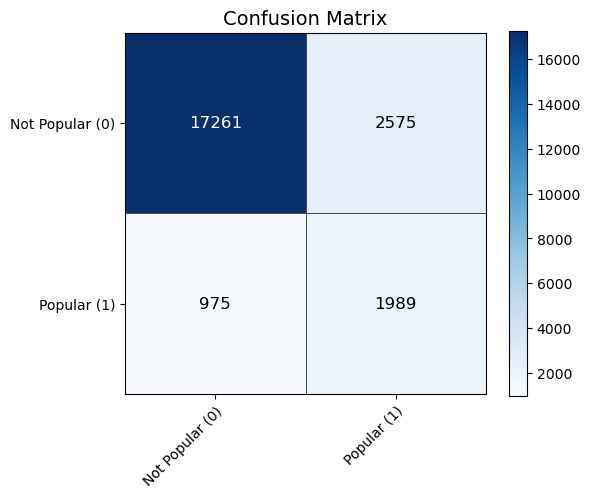

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
classes = ["Not Popular (0)", "Popular (1)"]

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

# Title & ticks
ax.set_title("Confusion Matrix", fontsize=14)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, fontsize=10)
ax.set_yticklabels(classes, fontsize=10)

# Rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate cells with contrast-aware text color
threshold = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "white" if cm[i, j] > threshold else "black"
        ax.text(j, i, cm[i, j],
                ha="center", va="center", color=color, fontsize=12)

# Add colorbar
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=10)

# Add gridlines
ax.set_xticks(np.arange(-.5, len(classes), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(classes), 1), minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", bottom=False, left=False)

plt.tight_layout()
plt.show()
